<a href="https://colab.research.google.com/github/casangi/cngi_prototype/blob/master/docs/fit_mulltiple_1d_gaussians.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

This notebook provides an example of how to fit multiple 1-d gaussians simultaneously in python as may be done in spec_fit. Code based on discussion at https://stackoverflow.com/questions/34136737/using-scipy-curve-fit-for-a-variable-number-of-parameters

Author: dmehring 12jan2022

Install casatools

In [80]:
import os
print("installing casatools (takes a minute)...")
os.system("apt-get install libgfortran3")
os.system("pip install casatools==6.3.0.48")
os.system('pip install casadata')
print('complete')

installing casatools (takes a minute)...
complete


imports

In [81]:
from casatools import functional
import numpy as np
from scipy.optimize import curve_fit
from matplotlib import pyplot as plt
from scipy.stats import chisquare

Define functions to determine rms and compute model values

In [82]:
def __rms(y):
  z = np.array(y) if type(y) == list else y
  return np.sqrt(np.sum(z*z)/len(z))

def __model(x, g1d):
  m = np.zeros(len(x))
  for g in g1d:
    m += g.f(x)
  return m

Define function to plot data

In [83]:
# plot the data
def __plot(x, y, gaussians, fit=False):
  plt.plot(x, y, linestyle='', marker='o', markerfacecolor='red')
  residual = []
  for i in range(len(x)):
    res = y[i]
    for g in gaussians:
      res -= g.f(i)
    residual.append(res)
  plt.plot(x, residual, linestyle='', marker='x', markerfacecolor='#50C878')
  plt.xlabel('V_LSR (km/s)')
  plt.ylabel('Intensity (Jy/beam')
  x_model = []
  model = []
  for i in np.linspace(np.min(x), np.max(x), 100):
    x_model.append(i)
    res = 0
    for g in gaussians:
      res += g.f(i)
    model.append(res)
  plt.plot(x_model, model, color='blue')

  if fit:
    plt.title('Model Spectrum with Fit')
  else:
    plt.title('Model Spectrum')
  plt.show()


Define wrapper function that is used to fit multiple gaussians
N = number of gaussians to fit

In [84]:
def wrapper_fit_func(x, N, *args):
  amp, center, fwhm = list(args[0][:N]), list(args[0][N:2*N]), list(args[0][2*N:3*N])
  g1d = []
  for i in range(N):
    g1d.append(fn.gaussian1d(amp[i], center[i], fwhm[i]))
  return __model(x, g1d)

Demonstrate how the fitting is done. Create some data and fit it.

In [85]:
# create a model with 2 gaussians
# first, create an array of 2 1-d gaussian functionals
fn = functional()
g1d = [
    fn.gaussian1d(amplitude=5, center=10, fwhm=4),
    fn.gaussian1d(amplitude=3, center=4, fwhm=6)
  ]

npixels = 20

# create some gaussian noise to add to the y values
noise = 0.2
r = np.random.normal(0, noise, npixels)

ngauss = len(g1d)

# populate the x and y arrays with data
x = list(range(20))
m = __model(x, g1d)
y = m + r

Compute and report the rms of the residuals

In [86]:
rms_orig = __rms(y - m)
print('rms of residuals:', round(rms_orig, 3))
chi2_orig = chisquare(y, m)[0]
print('chi2:', round(chi2_orig, 3))

rms of residuals: 0.19
chi2: 5507.132


Plot the data with the model overlaid

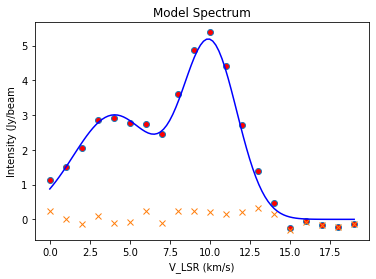

In [87]:
__plot(x, y, g1d)

Perform the fit of two 1-d gaussians to the data

In [88]:
# params_0 are the initial guesses for the parameters, which would normally
# be provided by the user
# they are in the order [amp0, amp1, ..., ampN, center0, center1, ..., centerN,
# fwhm0, fwhm1, ..., fwhmN]
params_0 = [4.5, 2, 9, 5, 5, 7]

# this line does the actual fit
popt, pcov = curve_fit(
      lambda x, *params_0:
        wrapper_fit_func(x, ngauss, params_0), x, y, p0=params_0
    )
# compute the estimated errors from the pcov diagonal
perr = np.sqrt(np.diag(pcov))

Summarize the fit

In [89]:
ndigits = 3
popt = popt.round(ndigits)
perr = perr.round(ndigits)
amp_fit = popt[0:ngauss]
center_fit = popt[ngauss:2*ngauss]
fwhm_fit = popt[2*ngauss:3*ngauss]
amp_err = perr[0:ngauss]
center_err = perr[ngauss:2*ngauss]
fwhm_err = perr[2*ngauss:3*ngauss]
for i in range(ngauss):
  print('Solution for gaussian {}:'.format(i))
  print('  Amplitude:', amp_fit[i], '+/-', amp_err[i])
  print('  Center:', center_fit[i], '+/-', center_err[i])
  print('  FWHM:', fwhm_fit[i], '+/-', fwhm_err[i])
  print()

g1d_fit = []
for i in range(ngauss):
  g1d_fit.append(fn.gaussian1d(amp_fit[i], center_fit[i], fwhm_fit[i]))

rms_fit = __rms(y - __model(x, g1d_fit))
print('rms of residuals of fit:', round(rms_fit, 3))
print(
    'Fit residuals have an rms that is {}% of the rms of the original residuals'
      .format(round(100*rms_fit/rms_orig, 3))
  )
print()
m = __model(x, g1d_fit)
chi2_fit = chisquare(y, m)[0]
print('chi-square of fit:', round(chi2_fit, 3))

print(
  'Chi-square of fit is {}% chi-square of original'
    .format(round(100*chi2_fit/chi2_orig, 3))
  )

Solution for gaussian 0:
  Amplitude: 5.134 +/- 0.166
  Center: 10.034 +/- 0.088
  FWHM: 4.111 +/- 0.174

Solution for gaussian 1:
  Amplitude: 2.92 +/- 0.106
  Center: 3.986 +/- 0.203
  FWHM: 6.339 +/- 0.554

rms of residuals of fit: 0.146
Fit residuals have an rms that is 76.932% of the rms of the original residuals

chi-square of fit: 2289.45
Chi-square of fit is 41.572% chi-square of original


Plot the data with the best fit model overlaid

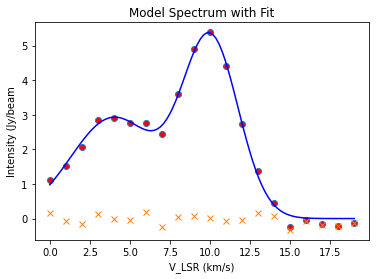

In [90]:
__plot(x, y, g1d_fit, True)        